### Compare local ancestry with inferred global ancestry in simpler model

In [4]:
# functions to get local ancestry with msprime
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import random
import collections
import msprime
import numpy as np
import seaborn as sns
import multiprocessing
import matplotlib.pyplot as plt

from IPython.display import SVG
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
# new imports
import sys
import itertools
from matplotlib import collections  as mc
from intervaltree import Interval, IntervalTree # thanks for the suggestion

# merge interval
def merge_intervals(intervals):
    """takes a list of (population-specific) ancestry intervals and combines them into contiguous intervals"""
    merged_intervals = []
    start = None
    stop = None
    for newstart, newstop in intervals:
        if start is None: # start first
            start = newstart
            stop = newstop
        elif np.allclose(newstart, stop): # extend
            stop = newstop
        else:  # end previous and start new 
            merged_intervals.append((start, stop))
            start = newstart
            stop = newstop
    # get terminal interval
    merged_intervals.append((start, newstop))
    return(np.array(merged_intervals))

# plot the merged segments
def plot_merged_segments(merged_segments_from_pop):
    """rough plot of local ancestry, plots the output of find_local_ancestry()"""
    fig, ax = plt.subplots(figsize=(10,2))
    for anc_pop, ms in merged_segments_from_pop.items():
        lines = zip(zip(ms[:,0], itertools.repeat(anc_pop)), zip(ms[:,1], itertools.repeat(anc_pop)))
        lc = mc.LineCollection(lines, linewidths=8)
        ax.add_collection(lc)
    ax.margins(0.1)
    maxpop = max(merged_segments_from_pop.keys())
    plt.ylim(-.2, maxpop+.2)
    plt.yticks(range(maxpop+1), range(maxpop+1))
    plt.ylabel('source population')
    plt.xlabel('bp position')

# find the local ancestry
def find_local_ancestry(sample, time, ts):
    """returns a dict.
    keys are the ancestral populations.
    values are the contiguous tracks of ancestry for the sample inherited from that pop.  
    Pops are defined at time """
    # put relevant migrations on an interval tree (otherwise too slow)
    mig_int_tree = IntervalTree()
    for migration in ts.migrations():
        if migration.time < time:
            mig_int_tree[migration.left:migration.right] = migration
    
    # for each tree, find the oldest node prior to [time]
    ancestor_before_timex_of_tree = dict()
    for tree in ts.trees():
        target = sample
        node_time = tree.time(target)
        parent_node = tree.parent(target)
        if parent_node != msprime.NULL_NODE:
            parent_time = tree.time(tree.parent(target))
        else:
            parent_time = time+1 
        while parent_time < time:
            node_time = parent_time
            target = tree.parent(target)
            parent_node = tree.parent(target)
            if parent_node != msprime.NULL_NODE:
                parent_time = tree.time(tree.parent(target))
            else:
                parent_time = time+1 
        ancestor_before_timex_of_tree[tree.index] = target
    
    # loop over trees and their relevant ancestors, find the pop that contributes to this sample 
    pop_at_time_of_parent = dict()
    pop_at_time_of_tree = dict()

    for tree in ts.trees():
        parent_node = ancestor_before_timex_of_tree[tree.index]
        # the original population of the node
        pop_at_time_of_parent[parent_node] = tree.population(parent_node)
        # trace the node back until [time], accounting for relevant migrations
        overlapping_intervals = mig_int_tree[tree.interval[0]]
        if len(overlapping_intervals) > 0:
            overlapping_migrations = [interval.data for interval in overlapping_intervals if interval.data.node == parent_node]
            if len(overlapping_migrations) > 0:
                #print len(overlapping_migrations)
                overlapping_migrations = sorted(overlapping_migrations, key = lambda x : x.time)
                #last_mig = overlapping_migrations[-1]#.pop()
                last_mig = overlapping_migrations.pop()
                #assert (pop_at_time_of_parent[parent_node] == mig.source), (parent_node, mig.time, pop_at_time_of_parent[parent_node], mig.source, mig.dest)
                pop_at_time_of_parent[parent_node] = last_mig.dest
        pop_at_time_of_tree[tree.index] = pop_at_time_of_parent[parent_node]
    
    # for each tree, record the interval and pop
    intervals_of_tree = dict()
    for tree in ts.trees():
        intervals_of_tree[tree.index] = tree.interval
    segments_from_pop = collections.defaultdict(list)
    for ti, anc_pop in pop_at_time_of_tree.items():
        segments_from_pop[anc_pop].append(intervals_of_tree[ti])

    # merge adjacent intervals from the same population
    merged_segments_from_pop = dict()
    for anc_pop in segments_from_pop:
        merged_segments_from_pop[anc_pop] = merge_intervals(segments_from_pop[anc_pop])  
    return(merged_segments_from_pop)

In [5]:
# my function to simulate 
# African American: European with African admixture 16 generations ago
# Note, this version deleted EUR-ASN split and all ASN-related migration event
import msprime, sys
from math import log
from math import exp
#seed = int(sys.argv[1])
#seed = 20
def run_simulation(random_seed=None):
    mu=1.25e-8 # mutation rate per bp
    rho=1e-8 # recombination rate per bp
    nbp=1e8 # generate 100Mb
    N0=7310 # initial population size
    Thum=5920 # time (gens) of advent of modern humans
    Naf=14474 # size of african population
    Tooa=2040 # number of generations back to Out of Africa
    Nb=1861 # size of out of africa population
    mafb=1.5e-4 # migration rate Africa and Out-of-Afica
    Teu=920 # number generations back to Asia-Euroupe split
    Neu=1032; Nas=554 # bottleneck population sizes
    mafeu=2.5e-5;mafas=7.8e-6;meuas=3.11e-5 #mig.rates
    reu=0.0038 #growth rate per generation in Europe
    ras=0.0048 #growth rate per generation in Asia
    Tadmix=16 # time of admixture
    Nadmix=30000 # initial size of admixed population
    radmix=.05 # growth rate of admixed population

    # pop0 is Africa, pop1 is Europe,  pop2 is admixed
    refsamplesize=200
    #admsamplesize=1000 #sample size of admixted pop
    admsamplesize=200
    pop_config = [
        msprime.PopulationConfiguration(sample_size=refsamplesize, initial_size=Naf), #growth_rate=0.0),
        msprime.PopulationConfiguration(sample_size=refsamplesize, initial_size=Neu*exp(reu*Teu)), #growth_rate=reu),
        msprime.PopulationConfiguration(sample_size=admsamplesize, initial_size=Nadmix*exp(radmix*Tadmix), )]#growth_rate=radmix)]
    mig_mat=[
        [0,mafeu,0],
        [mafeu,0,0],
        [0,0,0]]

    # Admixture event, 0.8 Africa, 0.2 Europe
    admixture_event = [
        msprime.MigrationRateChange(time=Tadmix, rate=0.0), #newly added, change the migration rate to 0
        msprime.MassMigration(time=Tadmix, source=2, destination=0, proportion=0.8), # African came to America        
        msprime.MassMigration(time=Tadmix+0.0001, source=2, destination=1, proportion=1.0)] # European came to America

    # Out of Africa event
    ooa_event = [
        msprime.MigrationRateChange(time=Tooa, rate=0.0),
        msprime.MassMigration(time=Tooa+0.0001, source=1, destination=0, proportion=1.0)
    ]

    # initial population size
    init_event=[msprime.PopulationParametersChange(time=Thum, initial_size=N0, population_id=0)]

    #events = admixture_event + eu_event + ooa_event + init_event
    events = admixture_event + ooa_event + init_event

    ts = msprime.simulate(
        population_configurations=pop_config,
        migration_matrix=mig_mat,
        demographic_events=events,
        length=nbp,
        recombination_rate=rho, 
        mutation_rate=mu,
        record_migrations=True, # newly added, Needed for tracking segments.
        random_seed=random_seed)
    return ts
ts = run_simulation(1)

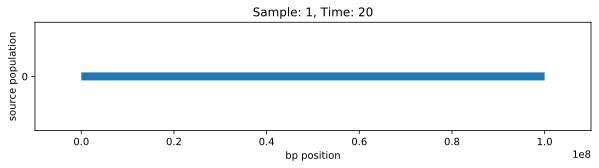

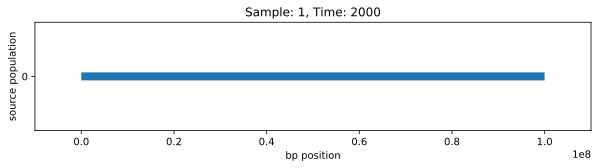

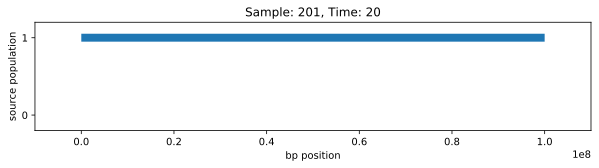

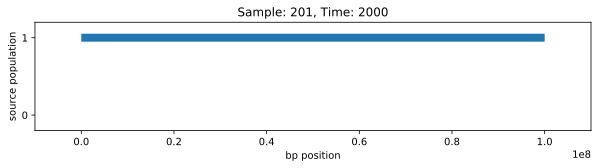

In [9]:
# test the code 
for sample in [1,201]:
    for time in [20, 2000]:
        la = find_local_ancestry(sample = sample, time = time, ts=ts)
        plot_merged_segments(la)
        plt.title('Sample: {}, Time: {}'.format(sample, time))

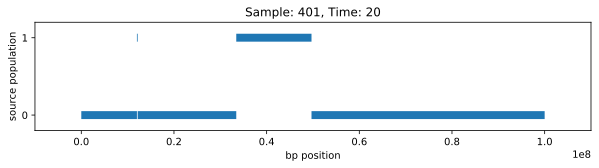

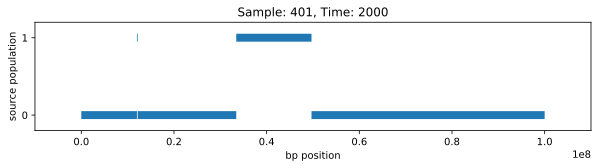

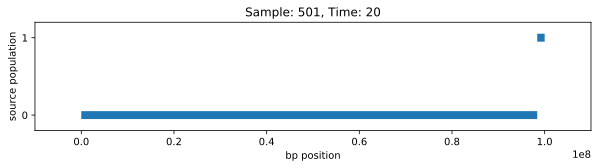

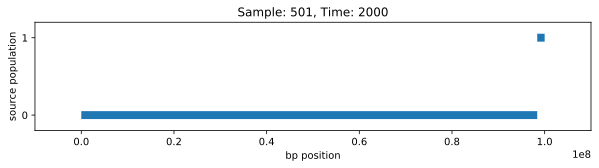

In [4]:
for sample in [401,501]:
    for time in [20, 2000]:
        la = find_local_ancestry(sample = sample, time = time, ts=ts)
        plot_merged_segments(la)
        plt.title('Sample: {}, Time: {}'.format(sample, time))

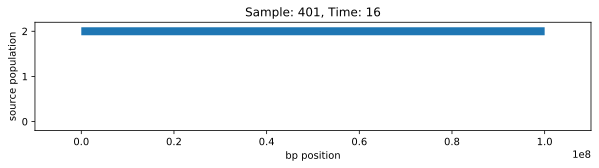

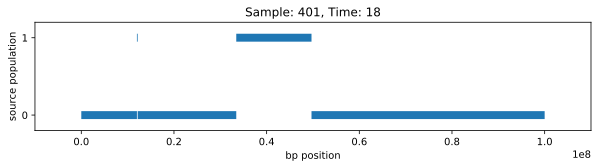

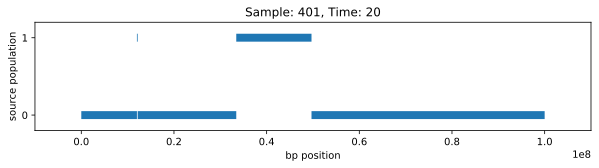

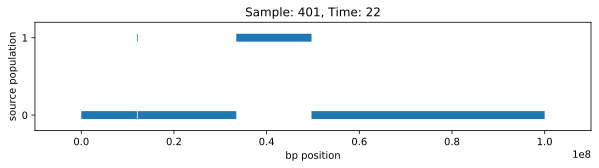

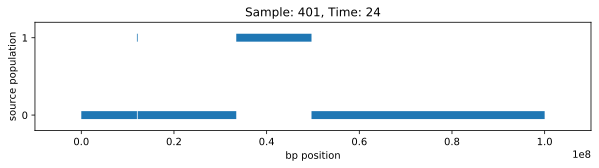

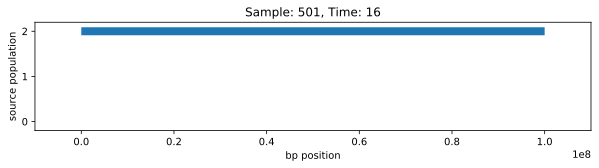

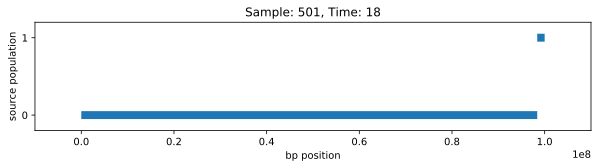

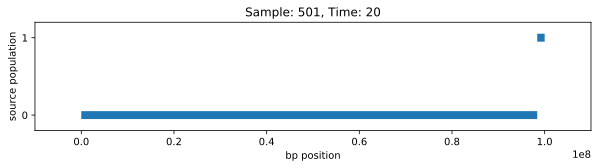

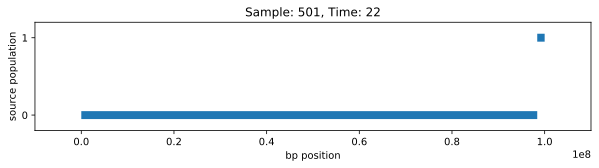

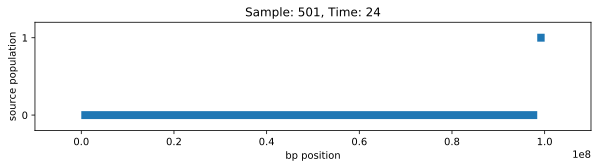

In [4]:
# other generation
for sample in [401,501]:
    for time in [16, 18, 20, 22, 24]:
        la = find_local_ancestry(sample = sample, time = time, ts=ts)
        plot_merged_segments(la)
        plt.title('Sample: {}, Time: {}'.format(sample, time))

In [23]:
# write the local ancestry out
sample=402
time=20
la=find_local_ancestry(sample = sample, time = time, ts=ts)
# Calculate global ancestry
AFR=la.get(0)
EUR=la.get(1)
def get_global_anc(x):
    j=0
    for i in range(len(x)):
        j=j+x[i,1]-x[i,0]
    return j/1e8
AFR_ga=get_global_anc(AFR)
EUR_ga=get_global_anc(EUR)
print(AFR_ga, EUR_ga)

0.8263773487010917 0.1736226512989083


In [ ]:
#function to calculate global anc from local anc results
def get_global_anc(x):
    j=0
    if (x==None) is True:
        j=j
    else:
        for i in range(len(x)):
            j=j+x[i,1]-x[i,0] 
    return j/1e8

# output admixed ppl's global anc
time=20
for sample in range(400,600):
    la=find_local_ancestry(sample = sample, time = time, ts=ts)
    AFR=la.get(0)
    EUR=la.get(1)
    AFR_ga=get_global_anc(AFR)
    EUR_ga=get_global_anc(EUR)
    f = open("sim_AA_global_anc.txt", "a")
    f.write(str(AFR_ga))
    f.write('\t')
    f.write(str(EUR_ga))
    f.write('\n')
f.close()

In [8]:
# export the simulated data 
# deal with Plink error "Sample ID ends with "_0", which induces an invalid IID of '0'." # code comes from https://tskit.readthedocs.io/en/latest/_modules/tskit/trees.html
# diploid
filename=f'AA_100Mb_adm.vcf'
n_dip_indv = int(ts.num_samples / 2)
indv_names = [f"AA_{str(i)}indv" for i in range(n_dip_indv)]
with open(filename, "w") as vcf_file:
    ts.write_vcf(vcf_file, ploidy=2, individual_names=indv_names)


In [20]:
#export to haplotype to validate simulated global anc
filename=f'AA_100Mb_adm_hap.vcf'
n_dip_indv = int(ts.num_samples)
indv_names = [f"AA_{str(i)}indv" for i in range(n_dip_indv)]
with open(filename, "w") as vcf_file:
    ts.write_vcf(vcf_file, ploidy=1, individual_names=indv_names)